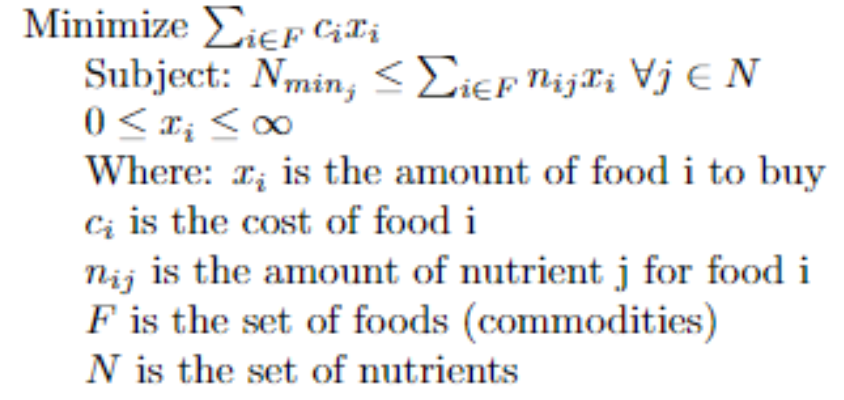

## Libraries

In [1]:
import os 
import numpy as np 
import pandas as pd 

from tqdm import tqdm

from ortools.linear_solver import pywraplp

import warnings

warnings.filterwarnings("ignore")


## Data

In [2]:
# Nutrient minimums.
nutrients = [
    ['Calcium (g)', 0.8],
    ['Calories (kcal)', 3],
    ['Iron (mg)', 12],
    ['Niacin (mg)', 18],
    ['Protein (g)', 70],
    ['Vitamin B2 (mg)', 2.7],    
    ['Vitamin B1 (mg)', 1.8],  
    ['Vitamin A (KIU)', 5],
    ['Vitamin C (mg)', 75],
]

In [3]:
wfp_ghana = pd.read_csv("../data/wfp_food_prices_gha_2019_2022_retail.csv")

In [4]:
wfp_ghana_10_2022 = wfp_ghana.loc[wfp_ghana.date=="2022-10-15"]

In [5]:
wfp_ghana_10_2022_accra = wfp_ghana_10_2022.loc[wfp_ghana_10_2022.market=="Kumasi"][["commodity", "price"]].reset_index(drop=True)

In [6]:
# price of commodity for 100g instead of 1Kg
wfp_ghana_10_2022_accra["price"] = wfp_ghana_10_2022_accra["price"]/10

In [7]:
commodities_nutrients = pd.read_csv("../data/commodities_nutrients.csv")

In [8]:
commodities_nutrients = commodities_nutrients.pivot(index="commodity", columns="Nutrient", values="Amount").fillna(0)

In [9]:
commodities_nutrients.sort_values("commodity")

Nutrient,Calcium,Calories,Iron,Niacin [Vitamin B3],Protein,Riboflavin [Vitamin B2],Thiamin [Vitamin B1],"Vitamin A, RAE",Vitamin C [Ascorbic acid]
commodity,,,,,,,,,
cassava_raw,16.0,160.0,0.27,0.854,1.36,0.048,0.087,1.0,20.6
chicken_raw_meat_only_stewing,10.0,148.0,1.09,7.477,21.26,0.207,0.149,32.0,3.3
corn_raw,2.0,86.0,0.52,1.770,3.27,0.055,0.155,9.0,6.8
corn_raw_yellow_sweet,2.0,86.0,0.52,1.770,3.27,0.055,0.155,9.0,6.8
cowpeas_raw_mature_seeds_catjang,85.0,343.0,9.95,2.795,23.85,0.170,0.680,2.0,1.5
eggplant_raw,9.0,25.0,0.23,0.649,0.98,0.037,0.039,1.0,2.2
fish_raw_atlantic_mackerel,12.0,205.0,1.63,9.080,18.60,0.312,0.176,50.0,0.4
gari_by_golden_tropics_ltd,71.0,357.0,2.57,0.000,0.00,0.000,0.000,0.0,0.0
millet_raw,8.0,378.0,3.01,4.720,11.02,0.290,0.421,0.0,0.0


In [10]:
print(sorted(wfp_ghana_10_2022_accra.commodity.unique()))

['Cassava', 'Cowpeas', 'Eggplants', 'Fish (mackerel, fresh)', 'Gari', 'Maize', 'Maize (yellow)', 'Meat (chicken)', 'Millet', 'Onions', 'Peppers (dried)', 'Plantains (apem)', 'Plantains (apentu)', 'Rice (imported)', 'Rice (local)', 'Sorghum', 'Soybeans', 'Tomatoes (navrongo)', 'Yam', 'Yam (puna)']


In [11]:
commodities_matching = {
    "Cassava": "cassava_raw",
    "Cowpeas": "cowpeas_raw_mature_seeds_catjang",
    "Eggplants": "eggplant_raw",
    "Fish (mackerel, fresh)": "fish_raw_atlantic_mackerel",
    "Gari": "gari_by_golden_tropics_ltd",
    "Maize": "corn_raw",
    "Maize (yellow)": "corn_raw_yellow_sweet",
    "Meat (chicken)": "chicken_raw_meat_only_stewing",
    "Millet": "millet_raw", 
    "Onions": "onions_raw",
    "Peppers (dried)": "peppers_dried_ancho",
    "Peppers (fresh)": "peppers_raw_red_sweet",
    "Plantains (apem)": "plantains_raw_green",
    "Plantains (apentu)": "plantains_raw_green",
    "Rice (imported)": "rice_raw_longgrain_brown",
    "Rice (local)": "rice_raw_longgrain_brown",
    "Sorghum": "sorghum_grain",
    "Soybeans": "soybeans_raw_mature_seeds",
    "Tomatoes (local)": "tomatoes_raw",
    "Tomatoes (navrongo)": "tomatoes_raw",
    "Yam": "yam_raw",
    "Yam (puna)": "yam_raw"
}

In [12]:
wfp_ghana_10_2022_accra["commodity2"] = wfp_ghana_10_2022_accra.commodity.apply(lambda x: commodities_matching[x])

In [13]:
data=pd.merge(wfp_ghana_10_2022_accra, commodities_nutrients, left_on=["commodity2"], right_on=["commodity"])

In [14]:
data = data.drop("commodity2", axis=1)

In [15]:
data

,commodity,price,Calcium,Calories,Iron,Niacin [Vitamin B3],Protein,Riboflavin [Vitamin B2],Thiamin [Vitamin B1],"Vitamin A, RAE",Vitamin C [Ascorbic acid]
0,Cassava,0.218,16.0,160.0,0.27,0.854,1.36,0.048,0.087,1.0,20.6
1,Gari,0.249,71.0,357.0,2.57,0.000,0.00,0.000,0.000,0.0,0.0
2,Maize,0.530,2.0,86.0,0.52,1.770,3.27,0.055,0.155,9.0,6.8
3,Maize (yellow),0.487,2.0,86.0,0.52,1.770,3.27,0.055,0.155,9.0,6.8
4,Millet,0.663,8.0,378.0,3.01,4.720,11.02,0.290,0.421,0.0,0.0
5,Rice (imported),0.880,9.0,367.0,1.29,6.494,7.54,0.095,0.541,0.0,0.0
6,Rice (local),0.867,9.0,367.0,1.29,6.494,7.54,0.095,0.541,0.0,0.0
7,Sorghum,0.663,13.0,329.0,3.36,3.688,10.62,0.096,0.332,0.0,0.0
8,Yam,0.289,17.0,118.0,0.54,0.552,1.53,0.032,0.112,7.0,17.1
9,Yam (puna),0.481,17.0,118.0,0.54,0.552,1.53,0.032,0.112,7.0,17.1


In [16]:
data.to_csv("../data/commodities_gha_nutrients.csv", index=False)

In [17]:
data = data.values.tolist()

## Solving for prices from August 2019 to October 2022

In [18]:
# Instantiate a Glop solver and naming it.
solver = pywraplp.Solver.CreateSolver('GLOP')

# Declare an array to hold our variables.
foods = [solver.NumVar(0.0, solver.infinity(), item[0]) for item in data]

print('Number of variables =', solver.NumVariables())

# Create the constraints, one per nutrient.
constraints = []
for i, nutrient in enumerate(nutrients):
    constraints.append(solver.Constraint(nutrient[1], solver.infinity()))
    for j, item in enumerate(data):
        constraints[i].SetCoefficient(foods[j], item[i + 2])

print('Number of constraints =', solver.NumConstraints())

# Objective function: Minimize the sum of (price-normalized) foods.
objective = solver.Objective()
for food in foods:
    objective.SetCoefficient(food, 1)
objective.SetMinimization()

status = solver.Solve()

# Check that the problem has an optimal solution.
if status != solver.OPTIMAL:
    print('The problem does not have an optimal solution!')
    if status == solver.FEASIBLE:
        print('A potentially suboptimal solution was found.')
    else:
        print('The solver could not solve the problem.')
        exit(1)

# Display the amounts (in dollars) to purchase of each food.
nutrients_result = [0] * len(nutrients)
print('\Mensual Foods:')
for i, food in enumerate(foods):
    if food.solution_value() > 0.0:
        print('{}: GHS{}'.format(data[i][0], 30. * food.solution_value()))
        for j, _ in enumerate(nutrients):
            nutrients_result[j] += data[i][j + 2] * food.solution_value()
print('\nOptimal mensual price: GHS{:.4f}'.format(30. * objective.Value()))

print('\nNutrients per day:')
for i, nutrient in enumerate(nutrients):
    print('{}: {:.2f} (min {})'.format(nutrient[0], nutrients_result[i],
                                       nutrient[1]))

print('\nAdvanced usage:')
print('Problem solved in ', solver.wall_time(), ' milliseconds')
print('Problem solved in ', solver.iterations(), ' iterations')

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Cassava: GHS94.83647773842611
Fish (mackerel, fresh): GHS33.96380139281782
Soybeans: GHS42.9154762249854
Peppers (dried): GHS12.645090340691393

Optimal mensual price: GHS184.3608

Nutrients per day:
Calcium (g): 486.13 (min 0.8)
Calories (kcal): 1494.33 (min 3)
Iron (mg): 29.77 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 82.56 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 491.97 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  2  milliseconds
Problem solved in  9  iterations


In [19]:
def find_cost_of_monthly_balanced_nutrition(market, date):
    import os 
    import numpy as np 
    import pandas as pd 

    from tqdm import tqdm

    from ortools.linear_solver import pywraplp

    import warnings

    warnings.filterwarnings("ignore")


    # Nutrient minimums.
    nutrients = [
        ['Calcium (g)', 0.8],
        ['Calories (kcal)', 3],
        ['Iron (mg)', 12],
        ['Niacin (mg)', 18],
        ['Protein (g)', 70],
        ['Vitamin B2 (mg)', 2.7],    
        ['Vitamin B1 (mg)', 1.8],  
        ['Vitamin A (KIU)', 5],
        ['Vitamin C (mg)', 75],
    ]

    wfp_ghana = pd.read_csv("../data/wfp_food_prices_gha_2019_2022_retail.csv")

    wfp_ghana_10_2022 = wfp_ghana.loc[wfp_ghana.date==date]

    wfp_ghana_10_2022_accra = wfp_ghana_10_2022.loc[wfp_ghana_10_2022.market==market][["commodity", "price"]].reset_index(drop=True)
    
    # price of commodity for 100g instead of 1Kg
    wfp_ghana_10_2022_accra["price"] = wfp_ghana_10_2022_accra["price"]/10

    commodities_nutrients = pd.read_csv("../data/commodities_nutrients.csv")

    commodities_nutrients = commodities_nutrients.pivot(index="commodity", columns="Nutrient", values="Amount").fillna(0)

    commodities_nutrients.sort_values("commodity")

    commodities_matching = {
        "Cassava": "cassava_raw",
        "Cowpeas": "cowpeas_raw_mature_seeds_catjang",
        "Eggplants": "eggplant_raw",
        "Fish (mackerel, fresh)": "fish_raw_atlantic_mackerel",
        "Gari": "gari_by_golden_tropics_ltd",
        "Maize": "corn_raw",
        "Maize (yellow)": "corn_raw_yellow_sweet",
        "Meat (chicken)": "chicken_raw_meat_only_stewing",
        "Millet": "millet_raw", 
        "Onions": "onions_raw",
        "Peppers (dried)": "peppers_dried_ancho",
        "Peppers (fresh)": "peppers_raw_red_sweet",
        "Plantains (apem)": "plantains_raw_green",
        "Plantains (apentu)": "plantains_raw_green",
        "Rice (imported)": "rice_raw_longgrain_brown",
        "Rice (local)": "rice_raw_longgrain_brown",
        "Sorghum": "sorghum_grain",
        "Soybeans": "soybeans_raw_mature_seeds",
        "Tomatoes (local)": "tomatoes_raw",
        "Tomatoes (navrongo)": "tomatoes_raw",
        "Yam": "yam_raw",
        "Yam (puna)": "yam_raw"
    }

    wfp_ghana_10_2022_accra["commodity2"] = wfp_ghana_10_2022_accra.commodity.apply(lambda x: commodities_matching[x])

    data=pd.merge(wfp_ghana_10_2022_accra, commodities_nutrients, left_on=["commodity2"], right_on=["commodity"])

    data = data.drop("commodity2", axis=1)

    data = data.values.tolist()

    # Instantiate a Glop solver and naming it.
    solver = pywraplp.Solver.CreateSolver('GLOP')

    # Declare an array to hold our variables.
    foods = [solver.NumVar(0.0, solver.infinity(), item[0]) for item in data]

    print('Number of variables =', solver.NumVariables())

    # Create the constraints, one per nutrient.
    constraints = []
    for i, nutrient in enumerate(nutrients):
        constraints.append(solver.Constraint(nutrient[1], solver.infinity()))
        for j, item in enumerate(data):
            constraints[i].SetCoefficient(foods[j], item[i + 2])

    print('Number of constraints =', solver.NumConstraints())

    # Objective function: Minimize the sum of (price-normalized) foods.
    objective = solver.Objective()
    for food in foods:
        objective.SetCoefficient(food, 1)
    objective.SetMinimization()

    status = solver.Solve()

    # Check that the problem has an optimal solution.
    if status != solver.OPTIMAL:
        print('The problem does not have an optimal solution!')
        if status == solver.FEASIBLE:
            print('A potentially suboptimal solution was found.')
        else:
            print('The solver could not solve the problem.')
            exit(1)

    # Display the amounts (in dollars) to purchase of each food.
    nutrients_result = [0] * len(nutrients)
    print('\Mensual Foods:')
    for i, food in enumerate(foods):
        if food.solution_value() > 0.0:
            print('{}: GHS{}'.format(data[i][0], 30. * food.solution_value()))
            for j, _ in enumerate(nutrients):
                nutrients_result[j] += data[i][j + 2] * food.solution_value()
    print('\nOptimal mensual price: GHS{:.4f}'.format(30. * objective.Value()))

    print('\nNutrients per day:')
    for i, nutrient in enumerate(nutrients):
        print('{}: {:.2f} (min {})'.format(nutrient[0], nutrients_result[i],
                                           nutrient[1]))

    print('\nAdvanced usage:')
    print('Problem solved in ', solver.wall_time(), ' milliseconds')
    print('Problem solved in ', solver.iterations(), ' iterations')
    
    return 30. * objective.Value()

In [20]:
find_cost_of_monthly_balanced_nutrition("Garu", "2021-10-15")

Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Cassava: GHS86.72751873762995
Fish (mackerel, fresh): GHS37.961329015332424
Soybeans: GHS74.704763733115

Optimal mensual price: GHS199.3936

Nutrients per day:
Calcium (g): 751.21 (min 0.8)
Calories (kcal): 1832.56 (min 3)
Iron (mg): 41.94 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 118.33 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.65 (min 1.8)
Vitamin A (KIU): 68.65 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  8  iterations


199.39361148607736

In [21]:
markets = []

dates = []

healthy_diet_minimum_costs = []

for market in wfp_ghana.market.unique():
    for date in wfp_ghana.date.unique():
        markets.append(market)
        dates.append(date)
        
        healthy_diet_minimum_costs.append(find_cost_of_monthly_balanced_nutrition(market, date))
        
        

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS23.32605638145032
Soybeans: GHS36.344423679489
Peppers (dried): GHS49.15033216868171
Peppers (fresh): GHS15.141995251258441

Optimal mensual price: GHS123.9628

Nutrients per day:
Calcium (g): 446.05 (min 0.8)
Calories (kcal): 1299.17 (min 3)
Iron (mg): 38.15 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 4.87 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1754.84 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  9  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 16
Number of constraints = 9
\Mensual Foods:
Millet: GHS85.1120543678245
Peppers (dried): GHS96.63746265734207
Peppers (fresh): GHS16.105912879289864

Optimal mensual price: GHS197.8554

Nutrients per day:
Calcium (g): 222.95 (min 0.8)
Calories (kcal): 1991.54 (min 3)
Iron (mg): 43.98 (min 12)
Niacin (mg): 34.54 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 8.13 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A 

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g): 240.99 (min 0.8)
Calories (kcal): 1165.56 (min 3)
Iron (mg): 31.77 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1086.03 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g):

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS44.41939901243823
Soybeans: GHS75.81391274315938
Peppers (fresh): GHS13.91815790083061

Optimal mensual price: GHS134.1515

Nutrients per day:
Calcium (g): 721.03 (min 0.8)
Calories (kcal): 1442.70 (min 3)
Iron (mg): 42.29 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.21 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.49 (min 1.8)
Vitamin A (KIU): 149.40 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  8  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS44.41939901243823
Soybeans: GHS75.81391274315938
Peppers (fresh): GHS13.91815790083061

Optimal mensual price: GHS134.1515

Nutrients per day:
Calcium (g): 721.03 (min 0.8)
Calories (kcal): 1442.70 (min 3)
Iron (mg): 42.29 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.21 (min 70)
Vitamin B2 (mg): 2.70 

Number of variables = 15
Number of constraints = 9
\Mensual Foods:
Millet: GHS14.123388188359376
Fish (mackerel, fresh): GHS212.13355774025786
Plantains (apem): GHS107.1854741041533

Optimal mensual price: GHS333.4424

Nutrients per day:
Calcium (g): 95.77 (min 0.8)
Calories (kcal): 2170.61 (min 3)
Iron (mg): 15.62 (min 12)
Niacin (mg): 68.39 (min 18)
Protein (g): 141.18 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 353.56 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Millet: GHS14.123388188359367
Fish (mackerel, fresh): GHS212.13355774025786
Plantains (apem): GHS107.18547410415329

Optimal mensual price: GHS333.4424

Nutrients per day:
Calcium (g): 95.77 (min 0.8)
Calories (kcal): 2170.61 (min 3)
Iron (mg): 15.62 (min 12)
Niacin (mg): 68.39 (min 18)
Protein (g): 141.18 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 353.56 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g): 240.99 (min 0.8)
Calories (kcal): 1165.56 (min 3)
Iron (mg): 31.77 (min 12)

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS32.632229474444635
Meat (chicken): GHS18.014240444351092
Soybeans: GHS33.60818649267627
Peppers (dried): GHS19.349786343523768
Peppers (fresh): GHS15.271764407913365

Optimal mensual price: GHS118.8762

Nutrients per day:
Calcium (g): 369.02 (min 0.8)
Calories (kcal): 1182.19 (min 3)
Iron (mg): 26.91 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 759.44 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS23.32605638145032
Soybeans: GHS36.344423679489
Peppers (dried): GHS49.15033216868171
Peppers (fresh): GHS15.141995251258441

Optimal mensual price: GHS123.9628

Nutrients per day:
Calcium (g): 446.05 (min 0.8)
Calories (kcal): 1299.17 (min 3)
Iron

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Millet: GHS31.876523962370683
Fish (mackerel, fresh): GHS225.37873132558778
Peppers (fresh): GHS16.913457380342717

Optimal mensual price: GHS274.1687

Nutrients per day:
Calcium (g): 102.60 (min 0.8)
Calories (kcal): 1956.39 (min 3)
Iron (mg): 15.69 (min 12)
Niacin (mg): 73.78 (min 18)
Protein (g): 152.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 464.14 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g):

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g):

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS12.5875708450005
Meat (chicken): GHS12.543438564041939
Cowpeas: GHS57.65727602347878
Peppers (dried): GHS29.282662102001456
Peppers (fresh): GHS16.159400270160067

Optimal mensual price: GHS128.2303

Nutrients per day:
Calcium (g): 234.63 (min 0.8)
Calories (kcal): 1163.37 (min 3)
Iron (mg): 31.02 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1099.35 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  8  iterations
Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS32.632229474444635
Meat (chicken): GHS18.014240444351092
Soybeans: GHS33.60818649267627
Peppers (dried): GHS19.349786343523768
Peppers (fresh): GHS15.271764407913365

Optimal mensual price: GHS118.8762

Nutrients per day:
Calcium (g): 369.02 (min 0.

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g): 240.99 (min 0.8)
Calories (kcal): 1165.56 (min 3)
Iron (mg): 31.77 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1086.03 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS32.632229474444635
Meat (chicken): GHS18.014240444351092
Soybeans: GHS33.60818649267627
Peppers (dried): GHS19.349786343523768
Peppers (fresh): GHS15.271764407913365

Optimal mensual price: GHS118.8762

Nutrients per day:
Calcium (g): 369.02 (min 0.8)
Calories (kcal): 1182.19 (min 3)
Iron (mg): 26.91 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 759.44 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  9  iterations
Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS23.32605638145033
Soybeans: GHS36.34442367948899
Peppers (dried): GHS49.150332168681715
Peppers (fresh): GHS15.141995251258438

Optimal mensual price: GHS123.9628

Nutrients per day:
Calcium (g): 446.05 (min 0.8)
Calories (kcal): 1299.17 (min 3)
I

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 16
Number of constraints = 9
\Mensual Foods:
Millet: GHS31.876523962370683
Fish (mackerel, fresh): GHS225.37873132558778
Peppers (fresh): GHS16.913457380342717

Optimal mensual price: GHS274.1687

Nutrients per day:
Calcium (g): 102.60 (min 0.8)
Calories (kcal): 1956.39 (min 3)
Iron (mg): 15.69 (min 12)


Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.69589176043727
Soybeans: GHS50.38566555295311
Peppers (dried): GHS10.147911244028368
Peppers (fresh): GHS14.96250452224001

Optimal mensual price: GHS117.1920

Nutrients per day:
Calcium (g): 506.03 (min 0.8)
Calories (kcal): 1142.01 (min 3)
Iron (mg): 32.55 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 91.64 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 495.18 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 19
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.69589176043727
Soybeans: GHS50.38566555295311
Peppers (dried): GHS10.147911244028368
Peppers (fresh): GHS14.96250452224001

Optimal mensual price: GHS117.1920

Nutrients per day:
Calcium (g): 506.03 (min 0.8)
Calories (kcal): 1142.01 (min 3)
Iron (mg): 32.55 (min 12)
Ni

Number of variables = 17
Number of constraints = 9
\Mensual Foods:
Millet: GHS14.123388188359367
Fish (mackerel, fresh): GHS212.13355774025786
Plantains (apem): GHS107.18547410415329

Optimal mensual price: GHS333.4424

Nutrients per day:
Calcium (g): 95.77 (min 0.8)
Calories (kcal): 2170.61 (min 3)
Iron (mg): 15.62 (min 12)
Niacin (mg): 68.39 (min 18)
Protein (g): 141.18 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 353.56 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS32.632229474444635
Meat (chicken): GHS18.014240444351092
Soybeans: GHS33.60818649267627
Peppers (dried): GHS19.349786343523768
Peppers (fresh): GHS15.271764407913365

Optimal mensual price: GHS118.8762

Nutrients per day:
Calcium (g): 369.0

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 17
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS59.79689224410876
Soybeans: GHS85.24377652154007
Peppers (fresh): GHS13.614231330233045

Optimal mensual price: GHS158.6549

Nutrients per day:
Calcium (g): 808.20 (min 0.8)
Calories (kcal): 2010.61 (min 3)
Iron (mg): 47.38 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 119.16 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 3.59 (min 1.8)
Vitamin A (KIU): 74.09 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  6  iterations
Number of variables = 17
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS44.41939901243823
Soybeans: GHS75.81391274315938
Peppers (fresh): GHS13.91815790083061

Optimal mensual price: GHS134.1515

Nutrients per day:
Calcium (g): 721.03 (min 0.8)
Calories (kcal): 1442.70 (min 3)
Iron (mg): 42.29 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.21 (min 70)
Vitamin B2 (mg): 2.70 (min 2.

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.69589176043726
Soybeans: GHS50.385665552953085
Peppers (dried): GHS10.147911244028386
Peppers (fresh): GHS14.962504522240017

Optimal mensual price: GHS117.1920

Nutrients per day:
Calcium (g): 506.03 (min 0.8)
Calories (kcal): 1142.01 (min 3)
Iron (mg): 32.55 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 91.64 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 495.18 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 17
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.69589176043726
Soybeans: GHS50.385665552953085
Peppers (dried): GHS10.147911244028386
Peppers (fresh): GHS14.962504522240017

Optimal mensual price: GHS117.1920

Nutrients per day:
Calcium (g): 506.03 (min 0.8)
Calories (kcal): 1142.01 (min 3)
Iron (mg): 32.55 (min 12

Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.145380253267945
Fish (mackerel, fresh): GHS18.77255905370636
Soybeans: GHS36.002742308588964
Peppers (dried): GHS17.659160163309366
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.145380253267945
Fish (mackerel, fresh): GHS18.77255905370636
Soybeans: GHS36.002742308588964
Peppers (dried): GHS17.659160163309366
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium 

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Cassava: GHS100.77226516296192
Fish (mackerel, fresh): GHS4.985524999327198
Meat (chicken): GHS9.875325334277077
Cowpeas: GHS55.69935221171045
Peppers (dried): GHS27.979762861286755

Optimal mensual price: GHS199.3122

Nutrients per day:
Calcium (g): 273.74 (min 0.8)
Calories (kcal): 1519.14 (min 3)
Iron (mg): 30.20 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 979.09 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS8.556137411647992
Fish (mackerel, fresh): GHS12.794612561540173
Cowpeas: GHS60.457144733120806
Peppers (dried): GHS28.61274592802802
Peppers (fresh): GHS16.421072404225892

Optimal mensual price: GHS126.8417

Nutrients per day:
Calcium (g): 240.99 (m

Number of variables = 7
Number of constraints = 9
\Mensual Foods:
Cassava: GHS104.63766786039423
Millet: GHS7.91530732246832
Fish (mackerel, fresh): GHS236.1601051896963

Optimal mensual price: GHS348.7131

Nutrients per day:
Calcium (g): 152.38 (min 0.8)
Calories (kcal): 2271.56 (min 3)
Iron (mg): 14.57 (min 12)
Niacin (mg): 75.70 (min 18)
Protein (g): 154.07 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 397.09 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 7
Number of constraints = 9
\Mensual Foods:
Cassava: GHS104.63766786039423
Millet: GHS7.91530732246832
Fish (mackerel, fresh): GHS236.1601051896963

Optimal mensual price: GHS348.7131

Nutrients per day:
Calcium (g): 152.38 (min 0.8)
Calories (kcal): 2271.56 (min 3)
Iron (mg): 14.57 (min 12)
Niacin (mg): 75.70 (min 18)
Protein (g): 154.07 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (

Number of variables = 8
Number of constraints = 9
\Mensual Foods:
Rice (local): GHS53.59349217166334
Yam: GHS102.28452778602981
Soybeans: GHS83.489095809815

Optimal mensual price: GHS239.3671

Nutrients per day:
Calcium (g): 844.92 (min 0.8)
Calories (kcal): 2299.15 (min 3)
Iron (mg): 47.84 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.24 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 3.78 (min 1.8)
Vitamin A (KIU): 26.65 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  8  iterations
Number of variables = 7
Number of constraints = 9
\Mensual Foods:
Rice (local): GHS53.59349217166334
Yam: GHS102.28452778602981
Soybeans: GHS83.489095809815

Optimal mensual price: GHS239.3671

Nutrients per day:
Calcium (g): 844.92 (min 0.8)
Calories (kcal): 2299.15 (min 3)
Iron (mg): 47.84 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.24 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 3.78 (min 1.8)
Vitamin

Number of variables = 7
Number of constraints = 9
\Mensual Foods:
Millet: GHS264.7912885662432
Yam (puna): GHS131.57894736842107

Optimal mensual price: GHS396.3702

Nutrients per day:
Calcium (g): 145.17 (min 0.8)
Calories (kcal): 3853.91 (min 3)
Iron (mg): 28.94 (min 12)
Niacin (mg): 44.08 (min 18)
Protein (g): 103.98 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 4.21 (min 1.8)
Vitamin A (KIU): 30.70 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 8
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.89455064444261
Soybeans: GHS67.6823121270321
Plantains (apentu): GHS90.4528864841599

Optimal mensual price: GHS200.0297

Nutrients per day:
Calcium (g): 647.72 (min 0.8)
Calories (kcal): 1750.78 (min 3)
Iron (mg): 39.96 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 112.07 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.52 (min 1.8)
Vitamin A (

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS23.32605638145032
Soybeans: GHS36.344423679489
Peppers (dried): GHS49.15033216868171
Peppers (fresh): GHS15.141995251258441

Optimal mensual price: GHS123.9628

Nutrients per day:
Calcium (g): 446.05 (min 0.8)
Calories (kcal): 1299.17 (min 3)
Iron (mg): 38.15 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 4.87 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1754.84 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  9  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  6  milliseconds
Problem solved in  0  iterations
Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Cassava: GHS100.77226516296192
Fish (mackerel, fresh): GHS4.985524999327198
Meat (chicken): GHS9.875325334277077
Cowpeas: GHS55.69935221171045
Peppers (dried): GHS27.979762861286755

Optimal mensual price: GHS199.3122

Nutrients per day:
Calcium (g): 273.74 (min 0.8)
Calories (kcal): 1519.14 (min 3)
Iron (mg): 30.20 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 7

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS59.79689224410876
Soybeans: GHS85.24377652154007
Peppers (fresh): GHS13.614231330233045

Optimal mensual price: GHS158.6549

Nutrients per day:
Calcium (g): 808.20 (min 0.8)
Calories (kcal): 2010.61 (min 3)
Iron (mg): 47.38 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 119.16 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 3.59 (min 1.8)
Vitamin A (KIU): 74.09 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  6  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vita

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Cassava: GHS86.72751873762995
Fish (mackerel, fresh): GHS37.961329015332424
Soybeans: GHS74.704763733115

Optimal mensual price: GHS199.3936

Nutrients per day:
Calcium (g): 751.21 (min 0.8)
Calories (kcal): 1832.56 (min 3)
Iron (mg): 41.94 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 118.33 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.65 (min 1.8)
Vitamin A

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS44.41939901243823
Soybeans: GHS75.81391274315938
Peppers (fresh): GHS13.91815790083061

Optimal mensual price: GHS134.1515

Nutrients per day:
Calcium (g): 721.03 (min 0.8)
Calories (kcal): 1442.70 (min 3)
Iron (mg): 42.29 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 120.21 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.49 (min 1.8)
Vitamin A (KIU): 149.40 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  8  iterations
Number of variables = 16
Number of constraints = 9
\Mensual Foods:
Millet: GHS31.876523962370683
Fish (mackerel, fresh): GHS225.37873132558778
Peppers (fresh): GHS16.913457380342717

Optimal mensual price: GHS274.1687

Nutrients per day:
Calcium (g): 102.60 (min 0.8)
Calories (kcal): 1956.39 (min 3)
Iron (mg): 15.69 (min 12)
Niacin (mg): 73.78 (min 18)
Protein (g): 152.00 (min 70)
Vitamin B2 (mg): 2.70

Number of variables = 14
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS41.8945506444426
Soybeans: GHS67.68231212703208
Plantains (apentu): GHS90.4528864841599

Optimal mensual price: GHS200.0297

Nutrients per day:
Calcium (g): 647.72 (min 0.8)
Calories (kcal): 1750.78 (min 3)
Iron (mg): 39.96 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 112.07 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.52 (min 1.8)
Vitamin A (KIU): 72.08 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  8  iterations
Number of variables = 15
Number of constraints = 9
\Mensual Foods:
Fish (mackerel, fresh): GHS38.86969868675908
Soybeans: GHS40.64371960234096
Peppers (dried): GHS10.53771476734592
Plantains (apentu): GHS97.50071155329499

Optimal mensual price: GHS187.5518

Nutrients per day:
Calcium (g): 418.75 (min 0.8)
Calories (kcal): 1462.55 (min 3)
Iron (mg): 29.66 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 7
Number of constraints = 9
\Mensual Foods:
Millet: GHS264.7912885662432
Yam: GHS131.57894736842104

Optimal mensual price: GHS396.3702

Nutrients per day:
Calcium (g): 145.17 (min 0.8)
Calories (kcal): 3853.91 (min 3)
Iron (mg): 28.94 (min 12)
Niacin (mg): 44.08 (min 18)
Protein (g): 103.98 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 4.21 (min 1.8)
Vitamin A (KIU): 30.70 (min 5)
Vitamin C (mg): 75.00 (min 7

Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS5.155051991804764
Cowpeas: GHS60.847020725426205
Peppers (dried): GHS50.08181613321244
Peppers (fresh): GHS16.120327616643973

Optimal mensual price: GHS132.2042

Nutrients per day:
Calcium (g): 279.54 (min 0.8)
Calories (kcal): 1241.82 (min 3)
Iron (mg): 38.88 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 4.17 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 1794.54 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  8  iterations
Number of variables = 18
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.145380253267945
Fish (mackerel, fresh): GHS18.77255905370636
Soybeans: GHS36.002742308588964
Peppers (dried): GHS17.659160163309366
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 20
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 21
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 17
Number of constraints = 9
\Mensual Foods:
Meat (chicken): GHS53.39590717021429
Soybeans: GHS79.17573611674322
Peppers (fresh): GHS12.519491696459152

Optimal mensual price: GHS145.0911

Nutrients per day:
Calcium (g): 751.78 (min 0.8)
Calories (kcal): 1451.35 (min 3)
Iron (mg): 43.55 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 134.56 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 2.59 (min 1.8)
Vitamin

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C (mg): 0.00 (min 75)

Advanced usage:
Problem solved in  0  milliseconds
Problem solved in  0  iterations
Number of variables = 0
Number of constraints = 9
The problem does not have an optimal solution!
The solver could not solve the problem.
\Mensual Foods:

Optimal mensual price: GHS0.0000

Nutrients per day:
Calcium (g): 0.00 (min 0.8)
Calories (kcal): 0.00 (min 3)
Iron (mg): 0.00 (min 12)
Niacin (mg): 0.00 (min 18)
Protein (g): 0.00 (min 70)
Vitamin B2 (mg): 0.00 (min 2.7)
Vitamin B1 (mg): 0.00 (min 1.8)
Vitamin A (KIU): 0.00 (min 5)
Vitamin C

In [22]:
costs = pd.DataFrame({
    "market": markets,
    "date": dates,
    "cost": healthy_diet_minimum_costs
})

In [23]:
import matplotlib.pyplot as plt

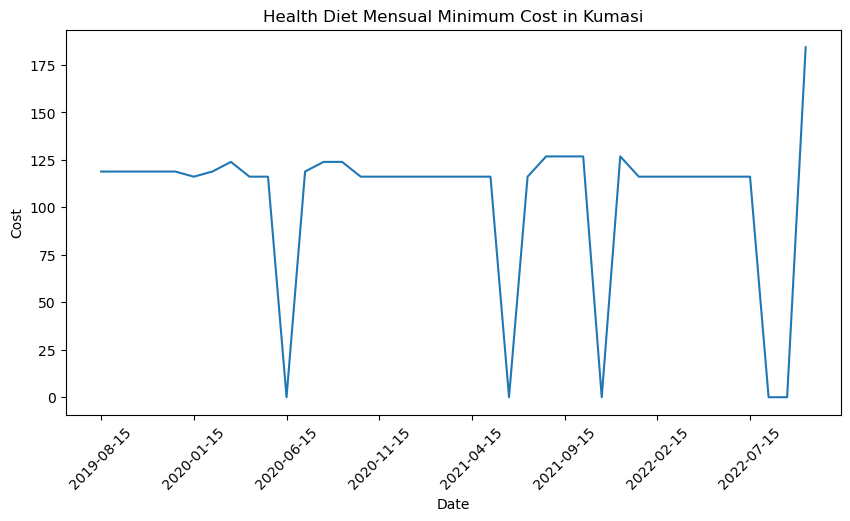

In [24]:
plt.figure(figsize=(10, 5))
costs.loc[costs.market=="Kumasi"].set_index("date")["cost"].plot()
plt.title("Health Diet Mensual Minimum Cost in Kumasi")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Cost")
plt.show()

## Solving for prices from November December 2022

In [25]:
forecast = pd.read_csv("../data/forecast.csv")

In [26]:
def find_cost_of_monthly_balanced_nutrition2(market, date):
    import os 
    import numpy as np 
    import pandas as pd 

    from tqdm import tqdm

    from ortools.linear_solver import pywraplp

    import warnings

    warnings.filterwarnings("ignore")


    # Nutrient minimums.
    nutrients = [
        ['Calcium (g)', 0.8],
        ['Calories (kcal)', 3],
        ['Iron (mg)', 12],
        ['Niacin (mg)', 18],
        ['Protein (g)', 70],
        ['Vitamin B2 (mg)', 2.7],    
        ['Vitamin B1 (mg)', 1.8],
        ['Vitamin A (KIU)', 5],
        ['Vitamin C (mg)', 75],
    ]

    wfp_ghana = pd.read_csv("../data/forecast.csv")
    
    wfp_ghana_10_2022 = wfp_ghana.loc[wfp_ghana.date==date]

    wfp_ghana_10_2022_accra = wfp_ghana_10_2022.loc[wfp_ghana_10_2022.market==market][["commodity", "price"]].reset_index(drop=True)
    
    # price of commodity for 100g instead of 1Kg
    wfp_ghana_10_2022_accra["price"] = wfp_ghana_10_2022_accra["price"]/10

    commodities_nutrients = pd.read_csv("../data/commodities_nutrients.csv")

    commodities_nutrients = commodities_nutrients.pivot(index="commodity", columns="Nutrient", values="Amount").fillna(0)

    commodities_nutrients.sort_values("commodity")

    commodities_matching = {
        "Cassava": "cassava_raw",
        "Cowpeas": "cowpeas_raw_mature_seeds_catjang",
        "Eggplants": "eggplant_raw",
        "Fish (mackerel, fresh)": "fish_raw_atlantic_mackerel",
        "Gari": "gari_by_golden_tropics_ltd",
        "Maize": "corn_raw",
        "Maize (yellow)": "corn_raw_yellow_sweet",
        "Meat (chicken)": "chicken_raw_meat_only_stewing",
        "Millet": "millet_raw", 
        "Onions": "onions_raw",
        "Peppers (dried)": "peppers_dried_ancho",
        "Peppers (fresh)": "peppers_raw_red_sweet",
        "Plantains (apem)": "plantains_raw_green",
        "Plantains (apentu)": "plantains_raw_green",
        "Rice (imported)": "rice_raw_longgrain_brown",
        "Rice (local)": "rice_raw_longgrain_brown",
        "Sorghum": "sorghum_grain",
        "Soybeans": "soybeans_raw_mature_seeds",
        "Tomatoes (local)": "tomatoes_raw",
        "Tomatoes (navrongo)": "tomatoes_raw",
        "Yam": "yam_raw",
        "Yam (puna)": "yam_raw"
    }

    wfp_ghana_10_2022_accra["commodity2"] = wfp_ghana_10_2022_accra.commodity.apply(lambda x: commodities_matching[x])

    data=pd.merge(wfp_ghana_10_2022_accra, commodities_nutrients, left_on=["commodity2"], right_on=["commodity"])

    data = data.drop("commodity2", axis=1)

    data = data.values.tolist()

    # Instantiate a Glop solver and naming it.
    solver = pywraplp.Solver.CreateSolver('GLOP')

    # Declare an array to hold our variables.
    foods = [solver.NumVar(0.0, solver.infinity(), item[0]) for item in data]

    print('Number of variables =', solver.NumVariables())

    # Create the constraints, one per nutrient.
    constraints = []
    for i, nutrient in enumerate(nutrients):
        constraints.append(solver.Constraint(nutrient[1], solver.infinity()))
        for j, item in enumerate(data):
            constraints[i].SetCoefficient(foods[j], item[i + 2])

    print('Number of constraints =', solver.NumConstraints())

    # Objective function: Minimize the sum of (price-normalized) foods.
    objective = solver.Objective()
    for food in foods:
        objective.SetCoefficient(food, 1)
    objective.SetMinimization()

    status = solver.Solve()

    # Check that the problem has an optimal solution.
    if status != solver.OPTIMAL:
        print('The problem does not have an optimal solution!')
        if status == solver.FEASIBLE:
            print('A potentially suboptimal solution was found.')
        else:
            print('The solver could not solve the problem.')
            exit(1)

    # Display the amounts (in dollars) to purchase of each food.
    nutrients_result = [0] * len(nutrients)
    print('\Mensual Foods:')
    for i, food in enumerate(foods):
        if food.solution_value() > 0.0:
            print('{}: GHS{}'.format(data[i][0], 30. * food.solution_value()))
            for j, _ in enumerate(nutrients):
                nutrients_result[j] += data[i][j + 2] * food.solution_value()
    print('\nOptimal mensual price: GHS{:.4f}'.format(30. * objective.Value()))

    print('\nNutrients per day:')
    for i, nutrient in enumerate(nutrients):
        print('{}: {:.2f} (min {})'.format(nutrient[0], nutrients_result[i],
                                           nutrient[1]))

    print('\nAdvanced usage:')
    print('Problem solved in ', solver.wall_time(), ' milliseconds')
    print('Problem solved in ', solver.iterations(), ' iterations')
    
    return 30. * objective.Value()

In [27]:
markets2 = []

dates2 = []

healthy_diet_minimum_costs2 = []

for market in forecast.market.unique():
    for date in forecast.date.unique():
        markets2.append(market)
        dates2.append(date)
        
        healthy_diet_minimum_costs2.append(find_cost_of_monthly_balanced_nutrition2(market, date))
        
        

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g): 387.92 (min 0.8)
Calories (kcal): 1186.75 (min 3)
Iron (mg): 27.73 (min 12)
Niacin (mg): 18.00 (min 18)
Protein (g): 70.00 (min 70)
Vitamin B2 (mg): 2.70 (min 2.7)
Vitamin B1 (mg): 1.80 (min 1.8)
Vitamin A (KIU): 715.68 (min 5)
Vitamin C (mg): 75.00 (min 75)

Advanced usage:
Problem solved in  1  milliseconds
Problem solved in  10  iterations
Number of variables = 22
Number of constraints = 9
\Mensual Foods:
Rice (imported): GHS28.14538025326792
Fish (mackerel, fresh): GHS18.772559053706356
Soybeans: GHS36.00274230858897
Peppers (dried): GHS17.65916016330936
Peppers (fresh): GHS15.592452640566684

Optimal mensual price: GHS116.1723

Nutrients per day:
Calcium (g):

In [28]:
costs2 = pd.DataFrame({
    "market": markets2,
    "date": dates2,
    "cost": healthy_diet_minimum_costs2
})

In [29]:
costs2

,market,date,cost
0,Ejura,2022-11-15,116.172294
1,Ejura,2022-12-15,116.172294
2,Kumasi,2022-11-15,116.172294
3,Kumasi,2022-12-15,116.172294
4,Obuasi,2022-11-15,116.172294
5,Obuasi,2022-12-15,116.172294
6,Kintampo,2022-11-15,116.172294
7,Kintampo,2022-12-15,116.172294
8,Sunyani,2022-11-15,116.172294
9,Sunyani,2022-12-15,116.172294


In [30]:
kumasi_oct_2022 = pd.DataFrame([[data[i][0], food.solution_value()*30] for i, food in enumerate(foods)])
kumasi_oct_2022.columns = ["commodity", "budget"]

In [34]:
kumasi_oct_2022

,commodity,budget
0,Cassava,94.836478
1,Gari,0.000000
2,Maize,0.000000
3,Maize (yellow),0.000000
4,Millet,0.000000
5,Rice (imported),0.000000
6,Rice (local),0.000000
7,Sorghum,0.000000
8,Yam,0.000000
9,Yam (puna),0.000000


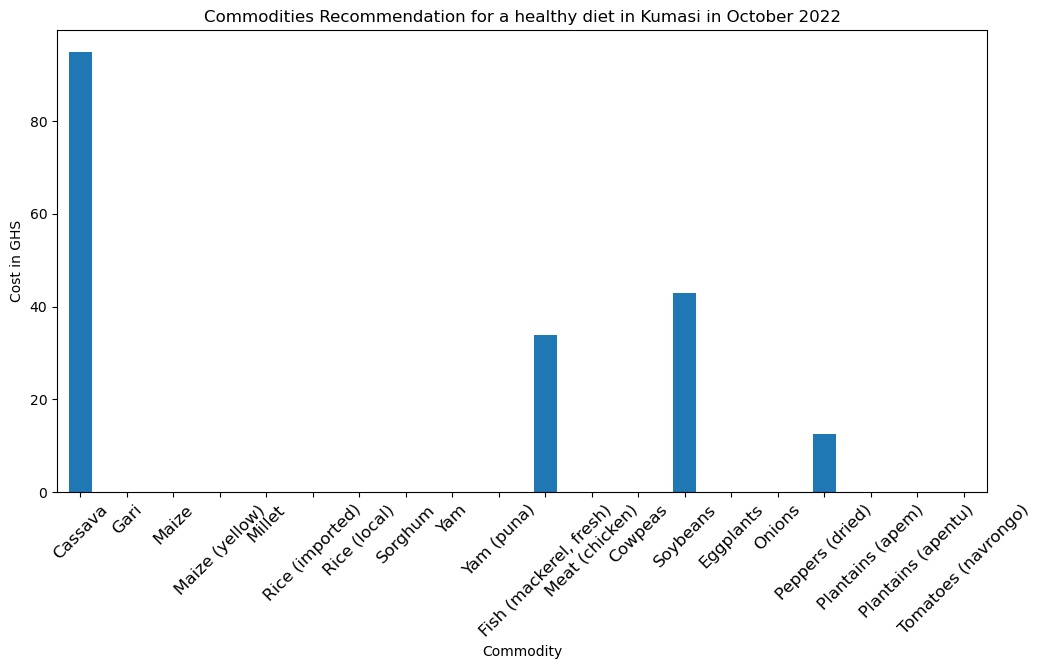

In [31]:
plt.figure(figsize=(12, 6))
kumasi_oct_2022.set_index("commodity")["budget"].plot(kind="bar")
plt.xlabel("Commodity")
plt.ylabel("Cost in GHS")
plt.title("Commodities Recommendation for a healthy diet in Kumasi in October 2022")
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [32]:
all_costs = pd.concat([costs, costs2])

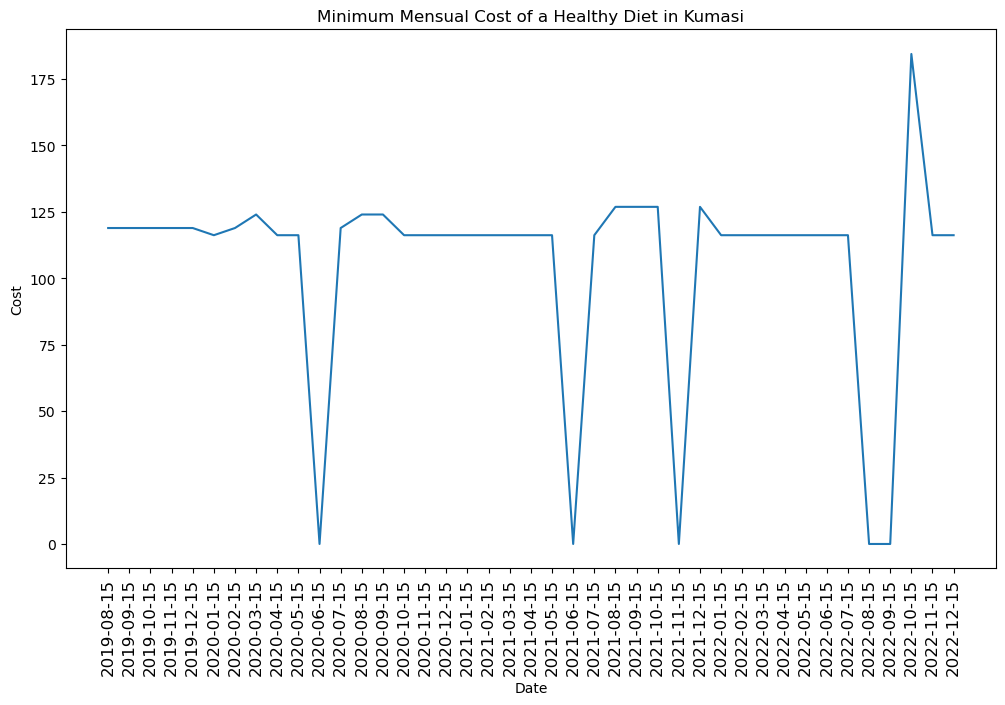

In [33]:
plt.figure(figsize=(12,7))
all_costs.loc[all_costs.market=="Kumasi"].set_index("date")["cost"].plot()
plt.title("Minimum Mensual Cost of a Healthy Diet in Kumasi")
plt.xlabel('Date')
plt.ylabel("Cost")
plt.xticks(ticks = range(0, 41), labels=all_costs.loc[all_costs.market=="Kumasi"]["date"].values.tolist(), rotation=90, fontsize=12)
# plt.legend()
plt.show()